This image is: <class 'numpy.ndarray'> with all dimesions: (540, 960, 3)
Images' relative path =  []
[MoviePy] >>>> Building video C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidWhiteRight_final_op1.mp4
[MoviePy] Writing video C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidWhiteRight_final_op1.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 221/222 [00:09<00:00, 23.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidWhiteRight_final_op1.mp4 

Wall time: 9.75 s


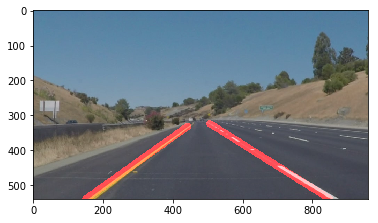

In [2]:

#importing all packages needed
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
get_ipython().magic('matplotlib inline')
import math
import os

import imageio
imageio.plugins.ffmpeg.download()
import glob


import glob
%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_function(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    """
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

l_prev_x1 = l_prev_y1 = l_prev_y2 = l_prev_x2 = l_abs_min_y = None
r_prev_x1 = r_prev_y1 = r_prev_y2 = r_prev_x2 = r_abs_min_y = None

def hough_lines_function(orig_img, img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    # line_img = np.zeros(img.shape, dtype=np.uint8)
    line_img = np.copy(orig_img) * 0  # creating a blank to draw lines on

    draw_lines_function(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines_function(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

#reading in an image
image = mpimg.imread('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidYellowCurve2.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with all dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


def draw_left_line_function(img, lines, color=[255, 0, 0], thickness=15):
    global l_prev_x1, l_prev_y1, l_prev_y2, l_prev_x2, l_abs_min_y

    abs_max_y = img.shape[0]

    # I would love to know how to compute average of each column 
    # in an array of tuples but being lazy here to focus on bigger 
    # challenges.
    all_y2 = []
    left_slopes = []
    left_intercepts = []

    for x1, y1, x2, y2, angle, m, b in lines:
        all_y2.append(y2)
        left_slopes.append(m)
        left_intercepts.append(b)

    # Find the mean of all slopes and y-intercepts to essentially center the final line along the lane line
    m = sum(left_slopes) / len(left_slopes)
    b = sum(left_intercepts) / len(left_intercepts)

    # Smooth out our y2 by remembering the smallest y2.
    # doesn't work well on curves at which point I would switch to a
    # different algorithm for curve analysis
    if l_abs_min_y is None:
        l_abs_min_y = min(all_y2)
    y2 = min(l_abs_min_y, min(all_y2))
    l_abs_min_y = y2
    
    y1 = abs_max_y
    x1 = int((y1 - b) / m)
    x2 = int((y2 - b) / m)
    
    # Smooth out the line
    α = 0.1
    if l_prev_y1 is not None:
        y1 = int(l_prev_y1 * (1 - α) + y1 * α)

    if l_prev_y2 is not None:
        y2 = int(l_prev_y2 * (1 - α) + y2 * α)

    if l_prev_x1 is not None:
        x1 = int(l_prev_x1 * (1 - α) + x1 * α)

    if l_prev_x2 is not None:
        x2 = int(l_prev_x2 * (1 - α) + x2 * α)

    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # keep our globals updated
    l_prev_y1 = y1
    l_prev_y2 = y2
    l_prev_x1 = x1
    l_prev_x2 = x2


def draw_right_line_function(img, lines, color=[255, 0, 0], thickness=15):
    global r_prev_x1, r_prev_y1, r_prev_y2, r_prev_x2, r_abs_min_y

    abs_max_y = img.shape[0]

    # I would love to know how to compute average of each column 
    # in an array of tuples but being lazy here to focus on bigger 
    # challenges.
    all_y1 = []
    slopes = []
    intercepts = []

    for x1, y1, x2, y2, angle, m, b in lines:
        all_y1.append(y1)
        slopes.append(m)
        intercepts.append(b)

    # Find the mean of all slopes and y-intercepts to essentially center the final line along the lane line
    m = sum(slopes) / len(slopes)
    b = sum(intercepts) / len(intercepts)

    # Smooth out our y1 by remembering the smallest y1
    # doesn't work well on curves at which point I would switch to a
    # different algorithm for curve analysis

    if r_abs_min_y is None:
        r_abs_min_y = min(all_y1)
    y1 = min(r_abs_min_y, min(all_y1))
    r_abs_min_y = y1

    x1 = int((r_abs_min_y - b) / m)
    y2 = abs_max_y
    x2 = int((y2 - b) / m)
    
    # Smooth out the line
    α = 0.1
    if r_prev_y1 is not None:
        y1 = int(r_prev_y1 * (1 - α) + y1 * α)

    if r_prev_y2 is not None:
        y2 = int(r_prev_y2 * (1 - α) + y2 * α)

    if r_prev_x1 is not None:
        x1 = int(r_prev_x1 * (1 - α) + x1 * α)

    if r_prev_x2 is not None:
        x2 = int(r_prev_x2 * (1 - α) + x2 * α)

    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # keep our globals updated
    r_prev_y1 = y1
    r_prev_y2 = y2
    r_prev_x1 = x1
    r_prev_x2 = x2


def draw_lines_function(img, lines, color=[255, 0, 0], thickness=20):

    if lines is None or len(lines) <= 0:
        return

    left_lines = []
    right_lines = []

    # This iteration splits each line into their respective line side bucket.
    # Negative line angles are left lane lines
    # Positive line angles are right lane lines
    # We also filter out outlier lines such as horizontal lines by specifying a
    # range of acceptable angles. There is definitely a better way but I feel
    # this is accurate enough for first pass.
    for line in lines:
        for x1, y1, x2, y2 in line:

            # compute the angle of the line
            angle = math.atan2(y2 - y1, x2 - x1) * 180.0 / np.pi
            m = (y2 - y1) / (x2 - x1)
            b = y1 - m * x1

            # left lane line
            if -40 < angle <= -30:
                left_lines.append(tuple((x1, y1, x2, y2, angle, m, b)))

            # right lane line
            elif 28 <= angle <= 45:
                right_lines.append(tuple((x1, y1, x2, y2, angle, m, b)))
            else:
                if len(right_lines) > 0:
                    right_lines.append(right_lines[len(right_lines) - 1])
                if len(left_lines) > 0:
                    left_lines.append(left_lines[len(left_lines) - 1])

    if len(left_lines) > 0:
        draw_left_line_function(img, left_lines, color, thickness)

    if len(right_lines) > 0:
        draw_right_line_function(img, right_lines, color, thickness)



# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def find_laneline(image):
    # call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    gray = grayscale(image)
    # plt.imshow(gray, cmap='gray')
    # plt.show()

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5  # Must be an odd number (3, 5, 7...)
    blur_gray = gaussian_function(gray, kernel_size)

    # Define our parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Display the image
    #plt.imshow(edges, cmap='Greys_r')
    #plt.show()


    # region mask

    # This time we are defining a four sided polygon to mask
    imshape = image.shape

    bottom_offset = 55
    img_height = imshape[0]
    img_width = imshape[1]

    # (W, H) == (x, y)
    vertices = np.array([
        [
            (bottom_offset, img_height),  # bottom left
            (img_width * 0.48, img_height * 0.60),  # top left
            (img_width * 0.54, img_height * 0.60),  # top right
            (img_width - bottom_offset, img_height)  # bottom right
        ]
    ], dtype=np.int32)

    # print('region of interest vertices: ', vertices)

    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    #
    # Defaults:
    # rho = 1
    # theta = np.pi/180
    # threshold = 1
    # min_line_length = 10
    # max_line_gap = 1

    rho = 2
    theta = np.pi / 180
    threshold = 40
    min_line_length = 10
    max_line_gap = 40

    result = hough_lines_function(image, masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))

    α = 0.8
    β = 1.
    λ = 0.
    result = weighted_img(result, image, α, β, λ)

    return result

dirs=os.listdir("C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/")


# Read in and make a list of calibration images
images9 = glob.glob('.C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/*.jpg')
print("Images' relative path = ", images9)

for fname in images9:
     #Read in each image
    img9 = mpimg.imread(fname)
    # Grayscale image
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dis=find_laneline(img9)
    plt.figure()
    plt.imshow(dis)
    
    

#for file in dirs:
#   imagew = mpimg.imread(file)
#    imageww=find_laneline(imagew)
#plt.imshow(imageww) #

#from PIL import Image
#import glob
#image_list = []
#for filename in glob.glob('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/*.jpg'): #assuming gif
#    im=find_laneline(filename)
#    plt.imshow(im)

# Read in the image - below working code
out_dir='C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/'
image1 = mpimg.imread('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidYellowLeft.jpg')
imgae_test=find_laneline(image1)
plt.imshow(imgae_test)
plt.imsave(out_dir+'straight_solidYellowLeft.jpg',imgae_test)

image2 = mpimg.imread('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/whiteCarLaneSwitch.jpg')
imgae_test2=find_laneline(image2)
plt.imshow(imgae_test2)
plt.imsave(out_dir+'straight_whiteCarLaneSwitch.jpg',imgae_test2)

image3 = mpimg.imread('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidYellowCurve2.jpg')
imgae_test3=find_laneline(image3)
plt.imshow(imgae_test3)
plt.imsave(out_dir+'straight_solidYellowCurve2.jpg',imgae_test3)

white_output = 'C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidWhiteRight_final_op1.mp4'
clip1 = VideoFileClip("C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/solidWhiteRight.mp4")
white_clip = clip1.fl_image(find_laneline)
get_ipython().magic('time white_clip.write_videofile(white_output, audio=False)')

#images1 = glob.glob('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/*.jpg')
# Visualize undistortion on test images

#for fname in images1:
#    cv2.imshow('dst',dst)
 #   cv2.waitKey(500)
